In [1]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from fourierSeries import fourier
from loadData import load_data

# order = 1000
order = 50
filename = "../A7_chord.wav"
# filename = "../sine_wave.wav"
batch_size = 1000
initial_learning_rate = 0.0001
epochs = 10000
gamma = 0.99
sequencer_steps = 10
learning_rate_params = {"initial_learning_rate": initial_learning_rate, "gamma": gamma, "sequencer_steps": sequencer_steps}


In [2]:
# tests for imported modules
# print(fourier(10, order))

train_data, train_labels, test_data, test_labels = load_data(filename,order)

# # type of train_data
# print("train_data")
# print(type(train_data))
# print(train_data.shape)

# # type of train_labels
# print("train_labels")
# print(type(train_labels))
# print(train_labels.shape)

# # type of test_data
# print("test_data")
# print(type(test_data))
# print(test_data.shape)

# # type of test_labels
# print("test_labels")
# print(type(test_labels))
# print(test_labels.shape)

Loading data


Loading data: 100%|██████████| 110250/110250 [00:04<00:00, 22229.76it/s]


In [3]:
# Custom dataset class
class CSVDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


In [4]:
class Net(nn.Module):
    def __init__(self, order):
        super().__init__()
        self.dims = 2*order + 1
        self.fc1 = nn.Linear(self.dims, self.dims)
        self.fc2 = nn.Linear(self.dims, 1)

    def forward(self, x):
        x = torch.flatten(x, -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

In [5]:
# data loader
train_dataset = CSVDataset(train_data, train_labels)
test_dataset = CSVDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# define the training function
def train(model, train_loader, criterion, optimizer, epochs):
    loss_list = []
    scheduler = StepLR(optimizer, step_size=sequencer_steps, gamma=gamma)
    for epoch in range(epochs+1):
        for input, data in enumerate(train_loader):
            input, labels = data
            labels = labels.unsqueeze(1)
            optimizer.zero_grad()
            output = model(input) + 1e-10
            loss = criterion(output, labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        scheduler.step()


        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + ", Loss: " + str(min(loss.item(),10)) + ", Learning rate: " + str(scheduler.get_last_lr()))
        if epoch % 100 == 0:
            print("Testing")
            test(model, test_loader)
        if epoch % 1000 == 0:
            print("Generating WAV")
            generateWAV(2,epoch)


    print("Epoch: " + str(epoch) + ", Loss: " + str(loss.item()) + ", Learning rate: " + str(scheduler.get_last_lr()))

    # use matplotlib to plot the loss
    plt.figure(figsize=(10,5))
    plt.title("Training Loss over Time")
    plt.plot(loss_list, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.yscale('log')
    plt.legend()
    plt.show()
                
    print("Finished Training")

In [16]:
# define the testing function

def test(model, test_loader):
    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data)
            loss = (output - labels).pow(2).sum()
            total_loss += loss.item()
            total_count += labels.numel()
            
    print(f"Average loss: {total_loss / total_count}")


In [17]:
# create an instance of the network
model = Net(order)

print(model.fc1.weight.dtype)
print(model.fc1.bias.dtype)
print(train_data[0].dtype)

# define the loss function and optimizer
criterion = nn.MSELoss()
# could integrate into train function to reduce lr over epochs
# changing the optimizer to Adam
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# run one forward pass on the first item in the train_loader
print(train_labels[0].item())
model.forward(train_data[0])

torch.float32
torch.float32
torch.float32
0.0


tensor([0.1036], grad_fn=<ReluBackward0>)

In [18]:
from generateWave import generate_wav

def generateWAV(seconds,epoch):
    new_wav_data = []
    freq = 44100
    for i in tqdm.tqdm(range(freq * seconds)):
        modelInput = torch.tensor(fourier(i, order), dtype=torch.float32)
        modelOutput = model.forward(modelInput).item()
        if modelOutput > 0:
            modelOutput = min(modelOutput,1)
        if modelOutput < 0:
            modelOutput = max(modelOutput,-1)
        new_wav_data.append(modelOutput)
    
    plt.plot(new_wav_data)
    plt.show()
    
    print(f"File Generated: ./WAV/new_wav_order_{order}_epoch_{epoch}.wav")
    generate_wav(f"./WAV/new_wav_order_{order}_epoch_{epoch}.wav", new_wav_data)


In [19]:
import matplotlib.pyplot as plt

def generateGraph(data):
    plt.plot(data)
    plt.show()


Epoch: 0, Loss: 2.2370615624822676e-05, Learning rate: [0.0001]
Testing
Average loss: 0.0216268548446167
Generating WAV


100%|██████████| 88200/88200 [00:07<00:00, 11417.66it/s]


File Generated: ./WAV/new_wav_order_50_epoch_0.wav


100%|██████████| 88200/88200 [00:00<00:00, 1215848.17it/s]
/Users/user/Documents/GitHub/MLPlayground/MLenv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/user/Documents/GitHub/MLPlayground/MLenv/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating 

ValueError: only one element tensors can be converted to Python scalars

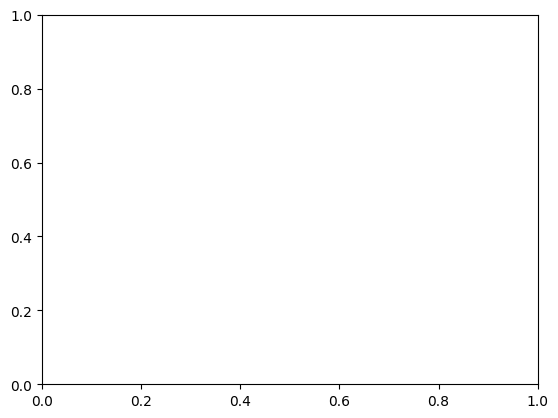

In [20]:
# train the network
train(model, train_loader, criterion, optimizer, epochs)

# test the network
test(model, test_loader)

In [ ]:
print(train_data[100])
print(model.forward(train_data[100]))

print(torch.tensor(fourier(100, order), dtype=torch.float32))
print(model.forward(torch.tensor(fourier(100, order), dtype=torch.float32)))

In [ ]:
# save the model
torch.save(model.state_dict(), f"fourierModel_order_{order}.pt")


In [ ]:
# load the model if needed
model = Net(order)
model.load_state_dict(torch.load(f"fourierModel_order_{order}.pt"))
model.eval()

In [ ]:


generateWAV(2,"final")

